In [1]:
import cv2, zarr, json, gc
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
gc.enable()

In [2]:
from config.global_vars import TILE_SHAPE

### Settings

In [3]:
path = Path('/home/jupyter/data_2/')
assert path.exists()
df_train = pd.read_csv(path/'train.csv')
df_info = pd.read_csv(path/'HuBMAP-20-dataset_information.csv')
g_out = zarr.group(f'/home/jupyter/anatomy')

In [4]:
df_info

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,aa05346ff.tiff,47340,30720,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,d488c759a.tiff,29020,46660,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35
5,e79de561c.tiff,27020,16180,e79de561c-anatomical-structure.json,e79de561c.json,67026,Black or African American,Not Hispanic or Latino,Male,53,73.0,166.0,26.5,Left,55,45
6,c68fe75ea.tiff,49780,26840,c68fe75ea-anatomical-structure.json,c68fe75ea.json,67112,White,Not Hispanic or Latino,Male,56,91.2,167.6,32.5,Left,80,20
7,095bf7a1f.tiff,39000,38160,095bf7a1f-anatomical-structure.json,095bf7a1f.json,68250,White,Not Hispanic or Latino,Female,44,71.7,160.0,28.0,Right,65,35
8,26dc41664.tiff,42360,38160,26dc41664-anatomical-structure.json,26dc41664.json,68304,White,Not Hispanic or Latino,Female,66,71.3,167.6,25.4,Left,55,45
9,57512b7f1.tiff,43160,33240,57512b7f1-anatomical-structure.json,57512b7f1.json,68555,White,Not Hispanic or Latino,Female,76,93.0,157.4,37.5,Left,80,20


aa05346ff test
30720 47340


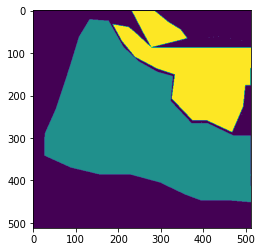

afa5e8098 train
36800 43780


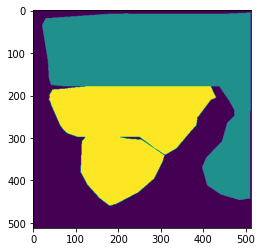

54f2eec69 train
30440 22240


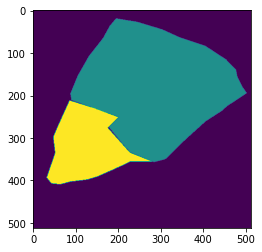

d488c759a test
46660 29020


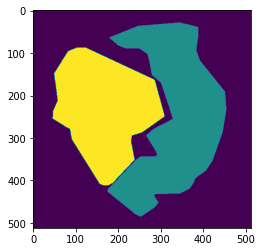

1e2425f28 train
26780 32220


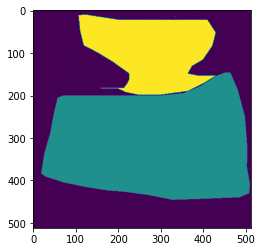

e79de561c train
16180 27020


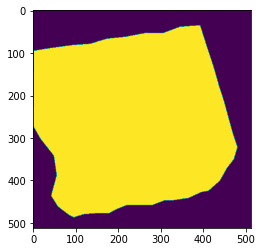

c68fe75ea train
26840 49780


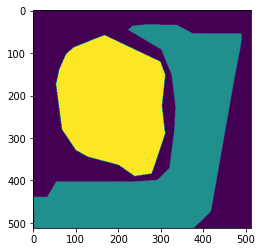

095bf7a1f train
38160 39000


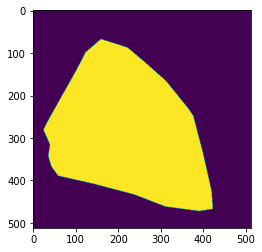

26dc41664 train
38160 42360


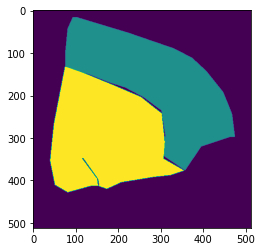

57512b7f1 test
33240 43160


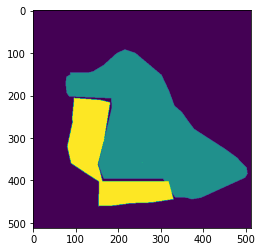

4ef6695ce train
39960 50680


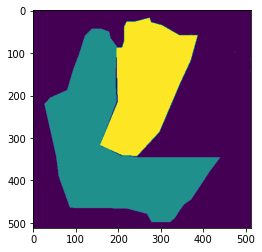

aaa6a05cc train
18484 13013


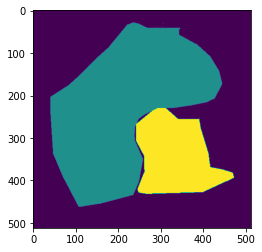

b9a3865fc train
31295 40429


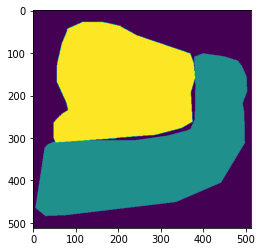

cb2d976f4 train
34940 49548


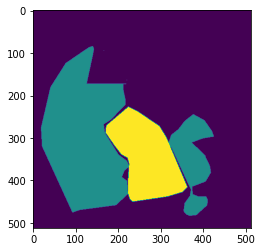

b2dc8411c train
14844 31262


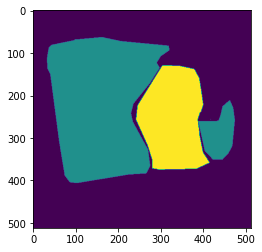

2ec3f1bb9 test
23990 47723


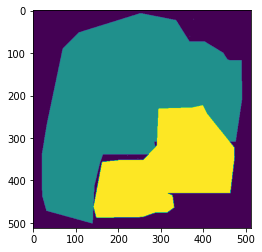

0486052bb train
25784 34937


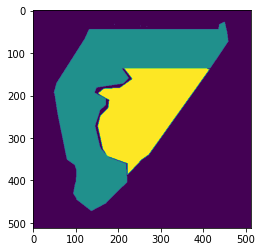

3589adb90 test
29433 22165


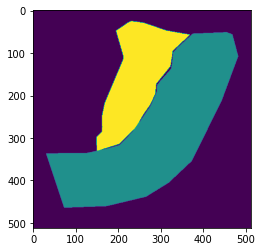

2f6ecfcdf train
31278 25794


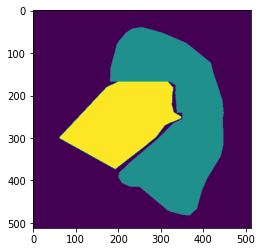

8242609fa train
31299 44066


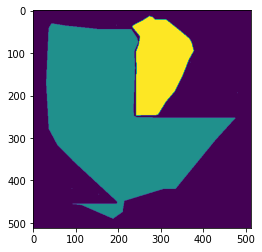

CPU times: user 52.7 s, sys: 32.3 s, total: 1min 25s
Wall time: 57.7 s


In [5]:
%%time

for _, row in df_info.iterrows():
    
#     print(row)
    idx = Path(row.image_file).stem
    split = 'train' if idx in df_train['id'].values else 'test'
    
    print(idx, split)
    
    with open(path/split/row.anatomical_structures_segmention_file) as json_file:
        data = json.load(json_file)
        
    # Empty mask
    umat = cv2.UMat(np.zeros((row.height_pixels, row.width_pixels), dtype=np.uint8))
    print(row.height_pixels, row.width_pixels)
    
    # Fill array
    for poly in data:
        coords = poly['geometry']['coordinates']
        value = 1 if poly['properties']['classification']['name'] == 'Cortex' else 2
        coords_cand = [coords] if len(coords) == 1 else coords
        for coord in coords_cand:
            coords2 = cv2.UMat(np.array([(int(a), int(b)) for a, b in coord[0]]))
            umat = cv2.fillConvexPoly(umat, coords2, value)
    
    g_out[idx] = umat.get()
    plt.imshow(cv2.resize(g_out[idx][:], dsize=(TILE_SHAPE, TILE_SHAPE)))
    plt.show()